#**Time Series Forecasting: Household Power Consumption**

In [1]:
!pip install ucimlrepo pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow -q

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)

# Combine features and targets into one DataFrame
df = X.copy()
df['target'] = y

# Save the complete dataset as a CSV
df.to_csv('complete_dataset.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

###**Step 1: Load Dataset without 'parse_dates**

In [4]:
data = pd.read_csv("complete_dataset.csv")
data.head(3)

<ipython-input-4-4f694ec16981>:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("complete_dataset.csv")


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,target
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,NaN
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,NaN
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,NaN


In [5]:
print(data.columns)

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'target'],
      dtype='object')


###**Step 2: Data Preprocessing**

In [6]:
# Combine 'Date' and 'Time' columns into a single 'datetime' column
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')

In [7]:
# Set 'datetime' column as the index
data.set_index('datetime', inplace=True)
print(data.columns)


Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'target'],
      dtype='object')


In [8]:
# data.set_index('datetime', inplace=True)
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data = data[['Global_active_power']].dropna()

###**Step 3: Exploratory Data Analysis**

In [9]:
# Resample to daily frequency, summing the power consumption for each day
daily_data = data.resample('D').sum()
# Ensure that 'daily_data' has no missing values
print("Missing values before dropna:", daily_data.isna().sum())  # Check before handling NaNs

Missing values before dropna: Global_active_power    0
dtype: int64


In [10]:
# Drop any remaining NaN values or fill them (e.g., forward fill)
daily_data = daily_data.dropna()  # Or use .fillna(method='ffill') for forward fill

In [11]:
# Check again after handling NaNs
print("Missing values after handling:", daily_data.isna().sum())  # Check after handling NaNs

Missing values after handling: Global_active_power    0
dtype: int64


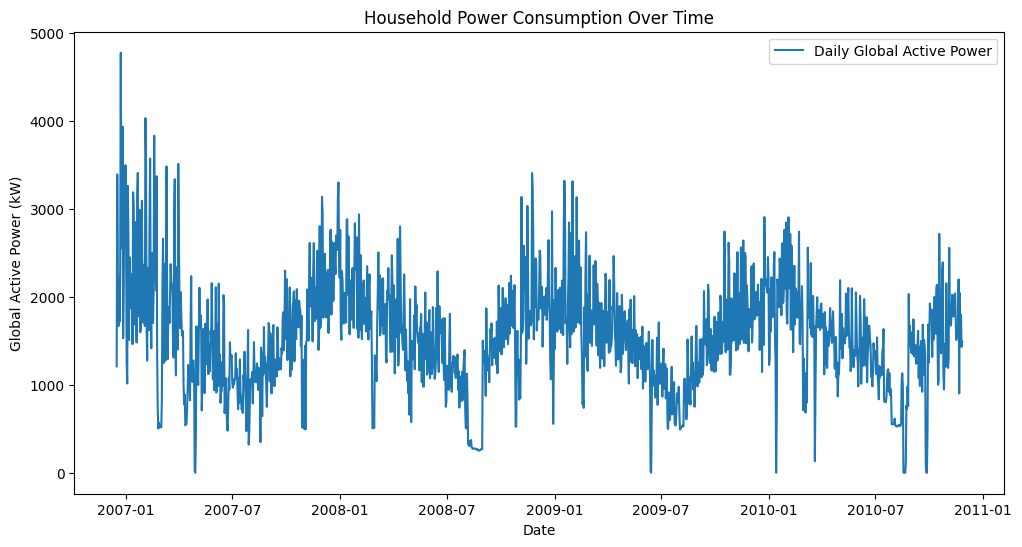

In [12]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(daily_data, label='Daily Global Active Power')
plt.title('Household Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

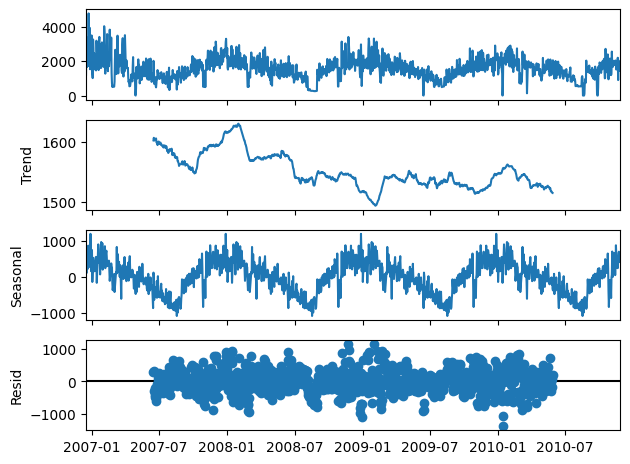

In [13]:
# Decompose time series
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(daily_data, model='additive', period=365)  # Specify period for yearly seasonality
decompose.plot()
plt.show()

###**Step 4: ARIMA Model**

In [14]:

# Split into train and test sets
train_size = int(len(daily_data) * 0.8)
train, test = daily_data[:train_size], daily_data[train_size:]

In [15]:
# Fit ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))
arima_result = arima_model.fit()

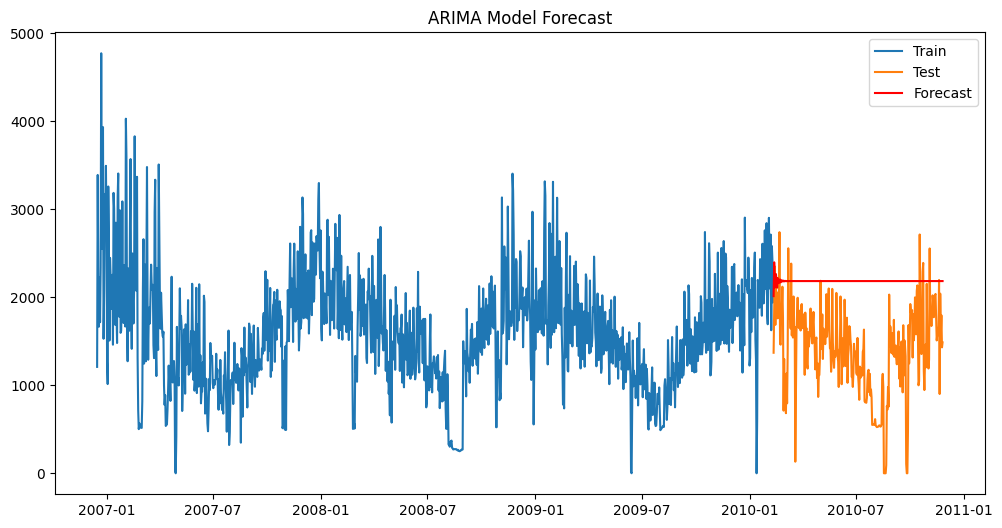

In [16]:
# Forecast
forecast = arima_result.forecast(steps=len(test))
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

In [17]:
# Evaluate ARIMA
arima_rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {arima_rmse:.2f}')

ARIMA RMSE: 933.33


###**Step 5: LSTM Model**

In [18]:

# Prepare data for LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_data)

In [19]:
# Create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

In [20]:
# Split into train and test
X_train, X_test = X[:train_size-sequence_length], X[train_size-sequence_length:]
y_train, y_test = y[:train_size-sequence_length], y[train_size-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0514
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0123
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0110
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0112
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0112
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0124
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0108
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0117
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0105
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0105


In [21]:
# Forecast with LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


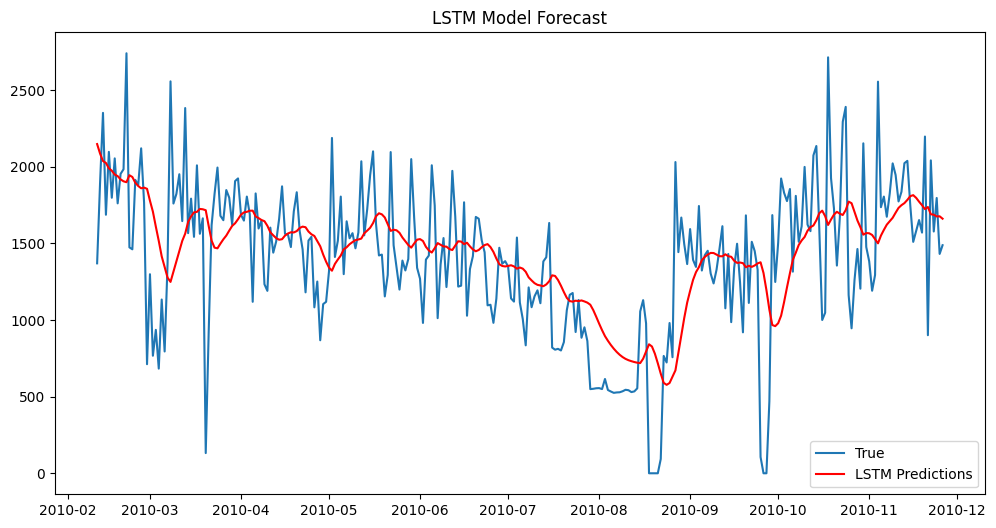

In [22]:
# Plot LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index[-len(y_test):], y_test_scaled, label='True')
plt.plot(daily_data.index[-len(y_test):], lstm_predictions, label='LSTM Predictions', color='red')
plt.title('LSTM Model Forecast')
plt.legend()
plt.show()

In [23]:
# Evaluate LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test_scaled, lstm_predictions))
print(f'LSTM RMSE: {lstm_rmse:.2f}')


LSTM RMSE: 411.84
